##### <img src="mioti.png" style="height: 100px">

# Challenge S5: Modelos regresivos aplicados a series temporales

## Nombre: Pablo Sagrera

## Objetivo

El objetivo de este challenge es usar nuestro dataframe de ventas en retail y hacer un modelo para la predicción de ventas para un artículo distinto del que vimos en el worksheet.

Tendréis que explorar los datos para ver el comportamiento del artículo elegido y las peculiaridades que pueda tener.

Luego tendréis que hacer un modelo que pueda predecir las ventas de este artículo usando todo lo aprendido anteriormente, probando distintos modelos, hiperparametrizándolos y por último añadiendo todas las variables sintéticas que veáis convenientes para que el modelo aprenda mejor del comportamiento de las unidades vendidas del producto.

## 1. Configuración del entorno

Cargamos los paquetes que vamos a utilizar en la sesión.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

## 2. Carga de los datos, filtrado de nuestro artículo y visualización de los datos
 



**Carga el dataframe**

In [2]:
dataRetail = pd.read_csv('Dataframe_Retail.csv', delimiter=',')
print(dataRetail['Referencia'].unique())

['Cerveza tercio' 'Baguetes 2 unidades' 'Aceite de oliva virgen extra 5 l'
 'Bolsa naranjas 2Kg.' 'Mandarina' 'Melo  OR' 'Jamón reserva'
 'Naranja en cajas' 'Pack de plátanos'
 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)' 'Tomate jugoso al peso'
 'Filetes de salmón' 'Sepia' 'Fresa premium 500gr']


**Usa una máscara para filtrar el artículo sobre el que queremos realizar las predicciones**

In [3]:
dataSku = dataRetail[dataRetail['Referencia']=='Jamón reserva']
dataSku['Fecha'] = pd.to_datetime(dataSku['Fecha'], format='%Y-%m-%d')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


** Ya que hemos cogido un producto que tiene huecos vamos a hacer una limpieza del dataframe ya que esos huecos originarían errores más tarde**

In [4]:
dataSku=dataSku.set_index('Fecha')

In [5]:
fechaMin = dataSku.index.min()
print(fechaMin)

2017-01-02 00:00:00


In [6]:
fechaMax = dataSku.index.max()
print(fechaMax)

2019-05-18 00:00:00


In [7]:
range = pd.date_range(start=fechaMin, end=fechaMax,freq='d')
dataSku = dataSku.reindex(range)
dataSku['Unidades']=dataSku['Unidades'].fillna(value=0)
dataSku['Ventas']=dataSku['Ventas'].fillna(value=0)
dataSku['Referencia']=dataSku['Referencia'].fillna(method='ffill')
dataSku=dataSku.reset_index()
dataSku=dataSku.rename(columns={'index':'Fecha Format'})
#dataSku['OffsetDays']=dataSku['OffsetDays'].astype(int)
dataSku['OffsetDays'] = dataSku.index

In [8]:
dataSku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha Format  867 non-null    datetime64[ns]
 1   Referencia    867 non-null    object        
 2   Unidades      867 non-null    float64       
 3   Ventas        867 non-null    float64       
 4   OffsetDays    867 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 34.0+ KB


In [9]:
dataSku.tail()

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
862,2019-05-14,Jamón reserva,90.495,1534.969995,862
863,2019-05-15,Jamón reserva,93.465,1653.959995,863
864,2019-05-16,Jamón reserva,99.870,1838.549994,864
865,2019-05-17,Jamón reserva,128.230,2309.240000,865
866,2019-05-18,Jamón reserva,137.430,2486.469991,866


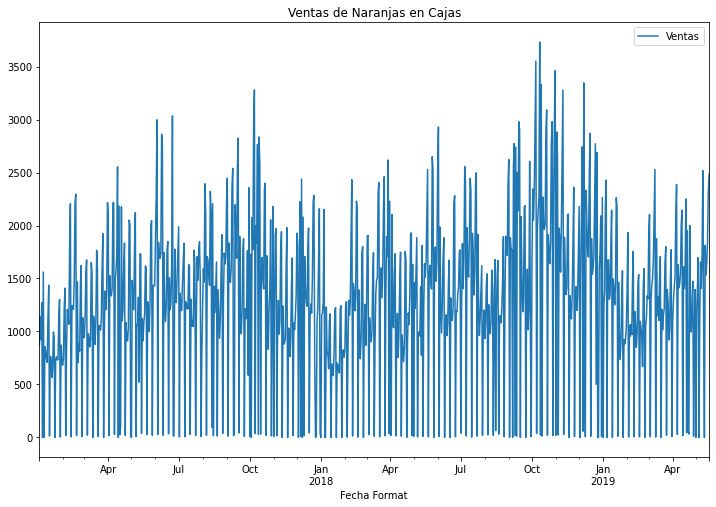

In [10]:
dataSku.plot(x='Fecha Format', y='Ventas', figsize=(12,8), title='Ventas de Jamon Reserva')

## 3. Prueba de la predicción sobre nuestras unidades vendidas con distintos modelos

** Con la función de evaluación puedes probar el funcionamiento de distintos modelos**

In [11]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in np.arange(800,861):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p)
        print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()

** Elige el modelo que más te haya gustado o mejor haya funcionado e hiperparametrizalo si quieres**

In [12]:
norma=False
dataSku_simple = dataSku[['OffsetDays','Unidades']].copy()
dataSku_simple.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OffsetDays  867 non-null    int64  
 1   Unidades    867 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.7 KB


Month 800 - Error 0.06216
Month 801 - Error 0.19483
Month 802 - Error 0.06944
Month 803 - Error 0.00356
Month 804 - Error 4.40274
Month 805 - Error 0.29926
Month 806 - Error 0.49020
Month 807 - Error 0.32339
Month 808 - Error 0.19830
Month 809 - Error 0.05716
Month 810 - Error 0.13004
Month 811 - Error 3.76772
Month 812 - Error 0.12791
Month 813 - Error 0.13785
Month 814 - Error 0.51919
Month 815 - Error 0.40460
Month 816 - Error 0.06773
Month 817 - Error 0.18645
Month 818 - Error 4.07179
Month 819 - Error 0.39012
Month 820 - Error 0.02406
Month 821 - Error 0.04139
Month 822 - Error 0.14763
Month 823 - Error 0.41856
Month 824 - Error 0.49572
Month 825 - Error 3.46692
Month 826 - Error 0.13753
Month 827 - Error 0.01870
Month 828 - Error 0.03431
Month 829 - Error 0.04547
Month 830 - Error 0.34998
Month 831 - Error 0.39761
Month 832 - Error 3.77072
Month 833 - Error 0.14227
Month 834 - Error 0.03801
Month 835 - Error 0.03768
Month 836 - Error 0.50312
Month 837 - Error 3.18738
Month 838 - 

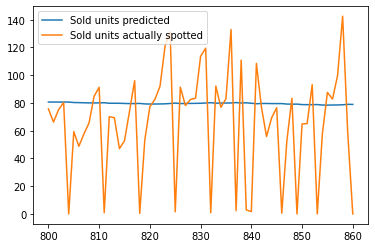

In [13]:
from sklearn.linear_model import LinearRegression
calculoEvaluacionModelo(LinearRegression(),dataSku_simple,norma)

Month 800 - Error 0.09723
Month 801 - Error 0.12755
Month 802 - Error 0.20372
Month 803 - Error 0.05353
Month 804 - Error 4.28306
Month 805 - Error 0.00348
Month 806 - Error 0.13932
Month 807 - Error 0.08894
Month 808 - Error 0.28028
Month 809 - Error 0.59639
Month 810 - Error 0.36332
Month 811 - Error 3.62848
Month 812 - Error 0.15270
Month 813 - Error 0.10279
Month 814 - Error 0.29103
Month 815 - Error 0.05320
Month 816 - Error 0.42834
Month 817 - Error 0.42078
Month 818 - Error 3.91438
Month 819 - Error 0.01363
Month 820 - Error 0.32862
Month 821 - Error 0.31100
Month 822 - Error 0.39093
Month 823 - Error 0.67582
Month 824 - Error 0.42753
Month 825 - Error 3.69771
Month 826 - Error 0.06348
Month 827 - Error 0.11172
Month 828 - Error 0.02646
Month 829 - Error 0.07985
Month 830 - Error 0.51598
Month 831 - Error 0.28261
Month 832 - Error 3.94294
Month 833 - Error 0.14043
Month 834 - Error 0.06242
Month 835 - Error 0.02945
Month 836 - Error 0.57330
Month 837 - Error 3.14872
Month 838 - 

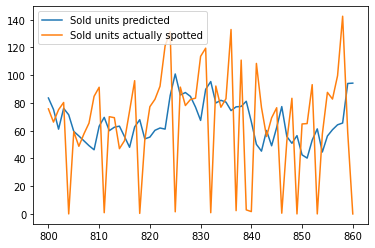

In [14]:
from sklearn.neighbors import KNeighborsRegressor
calculoEvaluacionModelo(KNeighborsRegressor(n_neighbors=5),dataSku_simple,norma)

Month 800 - Error 0.06167
Month 801 - Error 0.11278
Month 802 - Error 0.10474
Month 803 - Error 0.09154
Month 804 - Error 4.34875
Month 805 - Error 0.76886
Month 806 - Error 0.03072
Month 807 - Error 0.14811
Month 808 - Error 0.16367
Month 809 - Error 0.31814
Month 810 - Error 0.16745
Month 811 - Error 3.83539
Month 812 - Error 0.83445
Month 813 - Error 0.25354
Month 814 - Error 0.29056
Month 815 - Error 0.00007
Month 816 - Error 0.32815
Month 817 - Error 0.35005
Month 818 - Error 4.11798
Month 819 - Error 0.62642
Month 820 - Error 0.47454
Month 821 - Error 0.25749
Month 822 - Error 0.16714
Month 823 - Error 0.32462
Month 824 - Error 0.20387
Month 825 - Error 3.91931
Month 826 - Error 0.53545
Month 827 - Error 0.05175
Month 828 - Error 0.00536
Month 829 - Error 0.00133
Month 830 - Error 0.33218
Month 831 - Error 0.13871
Month 832 - Error 4.14207
Month 833 - Error 0.80863
Month 834 - Error 0.05540
Month 835 - Error 0.06826
Month 836 - Error 0.53741
Month 837 - Error 3.54699
Month 838 - 

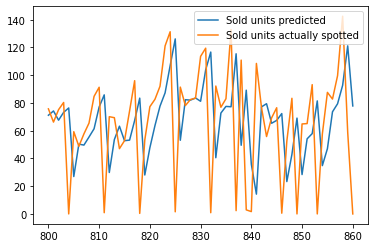

In [15]:
from sklearn.ensemble import RandomForestRegressor
calculoEvaluacionModelo(RandomForestRegressor(),dataSku_simple,norma)

Month 800 - Error 0.14333
Month 801 - Error 0.00032
Month 802 - Error 0.12957
Month 803 - Error 0.18999
Month 804 - Error 4.20973
Month 805 - Error 0.09912
Month 806 - Error 0.28973
Month 807 - Error 0.12378
Month 808 - Error 0.00098
Month 809 - Error 0.25045
Month 810 - Error 0.31787
Month 811 - Error 3.57970
Month 812 - Error 0.06731
Month 813 - Error 0.04614
Month 814 - Error 0.33656
Month 815 - Error 0.21194
Month 816 - Error 0.12486
Month 817 - Error 0.36751
Month 818 - Error 3.89045
Month 819 - Error 0.20159
Month 820 - Error 0.16446
Month 821 - Error 0.21858
Month 822 - Error 0.32429
Month 823 - Error 0.59578
Month 824 - Error 0.67527
Month 825 - Error 3.28452
Month 826 - Error 0.32727
Month 827 - Error 0.16106
Month 828 - Error 0.21320
Month 829 - Error 0.22426
Month 830 - Error 0.52874
Month 831 - Error 0.57813
Month 832 - Error 3.58809
Month 833 - Error 0.33219
Month 834 - Error 0.14201
Month 835 - Error 0.21676
Month 836 - Error 0.68217
Month 837 - Error 3.00546
Month 838 - 

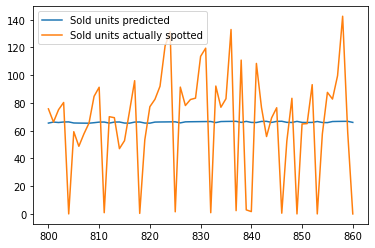

In [16]:
from sklearn.svm import SVR
calculoEvaluacionModelo(SVR(kernel='rbf', gamma='auto'),dataSku_simple,norma)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 800 - Error 0.17126
Month 801 - Error 0.23488
Month 802 - Error 0.30797
Month 803 - Error 0.20409
Month 804 - Error 4.68273
Month 805 - Error 0.56527
Month 806 - Error 0.85256
Month 807 - Error 0.60426


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 808 - Error 0.27635
Month 809 - Error 0.30606


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 810 - Error 0.11808


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 811 - Error 4.10306


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 812 - Error 0.36870
Month 813 - Error 0.28278


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 814 - Error 0.65467


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 815 - Error 0.56234
Month 816 - Error 0.35346


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 817 - Error 0.08580
Month 818 - Error 4.43151
Month 819 - Error 0.70134
Month 820 - Error 0.08148


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 821 - Error 0.08897
Month 822 - Error 0.10248
Month 823 - Error 0.34840


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 824 - Error 0.32931


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 825 - Error 3.72745


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 826 - Error 0.01242


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 827 - Error 0.28399


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 828 - Error 0.11554


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 829 - Error 0.12541


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 830 - Error 0.11584


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 831 - Error 0.17133


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 832 - Error 3.95869
Month 833 - Error 0.16047


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 834 - Error 0.19152


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 835 - Error 0.18970


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 836 - Error 0.32680


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 837 - Error 3.28424


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 838 - Error 0.11015


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 839 - Error 3.20138


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 840 - Error 3.57136


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 841 - Error 0.11699


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 842 - Error 0.12364


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 843 - Error 0.50437


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 844 - Error 0.27105


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 845 - Error 0.21006


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 846 - Error 4.10605
Month 847 - Error 0.63104


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 848 - Error 0.09644


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 849 - Error 4.57810
Month 850 - Error 0.44550


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 851 - Error 0.45338


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 852 - Error 0.00148


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 853 - Error 4.54031


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 854 - Error 0.47745


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 855 - Error 0.03249


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 856 - Error 0.13582


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 857 - Error 0.09482


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 858 - Error 0.45970


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Month 859 - Error 0.47195
Month 860 - Error 4.54453
Mean Error = 1.02720


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


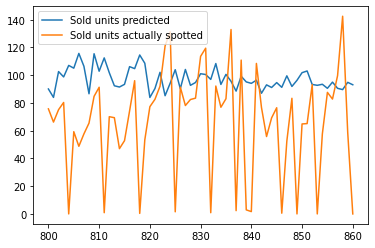

In [17]:
from sklearn.neural_network import MLPRegressor
calculoEvaluacionModelo(MLPRegressor(random_state=1976,max_iter=200),dataSku_simple,norma)

In [18]:
# El modelo con mejor prediccion es el RandomForestRegressor
# Es de notar que aunque el Mean Error de este modelo comparado con los otros es similar, la prediccion se ajusta
# mucho mas a los valores originales

## 4. Complementar el dataframe con variables sintéticas

** En base a lo que hayas observado en el comportamiento de las unidades vendidas de tu referencia crea variables sintéticas que creas que ayuden al modelo a mejorar la predicción**

In [19]:
# Creamos como variables sinteticas 'Lags y diferencias'

dataSku_simple2 = dataSku_simple.copy()
dataSku_simple2['Unidades_prev'] = dataSku_simple2['Unidades'].shift()
dataSku_simple2['Unidades_Diff'] = dataSku_simple2['Unidades_prev'].diff()
dataSku_simple2.head(10)

,OffsetDays,Unidades,Unidades_prev,Unidades_Diff
0,0,48.515,NaN,NaN
1,1,63.325,48.515,NaN
2,2,42.230,63.325,14.810
3,3,58.165,42.230,-21.095
4,4,0.000,58.165,15.935
5,5,71.330,0.000,-58.165
6,6,0.075,71.330,71.330
7,7,39.155,0.075,-71.255
8,8,37.225,39.155,39.080
9,9,34.055,37.225,-1.930


In [20]:
# Eliminamos los NaN del principio cuando se crean las variables sinteticas
dataSku_simple2 = dataSku_simple2.dropna()

Month 800 - Error 0.10357
Month 801 - Error 0.16151
Month 802 - Error 0.01150
Month 803 - Error 0.13777
Month 804 - Error 4.34783
Month 805 - Error 0.22540
Month 806 - Error 0.15429
Month 807 - Error 0.08671
Month 808 - Error 0.17037
Month 809 - Error 0.30576
Month 810 - Error 0.62686
Month 811 - Error 3.85458
Month 812 - Error 0.19284
Month 813 - Error 0.03457
Month 814 - Error 0.32536
Month 815 - Error 0.02489
Month 816 - Error 0.25858
Month 817 - Error 0.28991
Month 818 - Error 3.87843
Month 819 - Error 0.16041
Month 820 - Error 0.25273
Month 821 - Error 0.18364
Month 822 - Error 0.65507
Month 823 - Error 0.87214
Month 824 - Error 0.51543
Month 825 - Error 2.75361
Month 826 - Error 0.03598
Month 827 - Error 0.05508
Month 828 - Error 0.08971
Month 829 - Error 0.07141
Month 830 - Error 0.37803
Month 831 - Error 0.17837
Month 832 - Error 3.67766
Month 833 - Error 0.07699
Month 834 - Error 0.09122
Month 835 - Error 0.02488
Month 836 - Error 0.31489
Month 837 - Error 2.87413
Month 838 - 

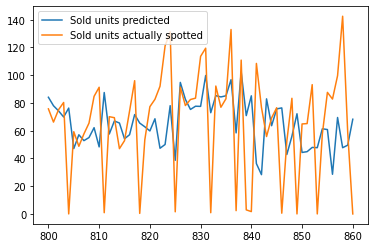

In [21]:
from sklearn.ensemble import RandomForestRegressor
calculoEvaluacionModelo(RandomForestRegressor(),dataSku_simple2,norma)

In [22]:
dataSku_simple3 = dataSku_simple.copy()
dataSku_simple3['Unidades_prev'] = dataSku_simple3['Unidades'].shift()
dataSku_simple3['Unidades_prev_2'] = dataSku_simple3['Unidades'].shift(2)
dataSku_simple3['Unidades_prev_3'] = dataSku_simple3['Unidades'].shift(3)
dataSku_simple3['Unidades_prev_4'] = dataSku_simple3['Unidades'].shift(4)
dataSku_simple3['Unidades_Diff'] = dataSku_simple3['Unidades_prev'].diff()
dataSku_simple3['Unidades_Diff_2'] = dataSku_simple3['Unidades_prev'].diff(2)
dataSku_simple3['Unidades_Diff_3'] = dataSku_simple3['Unidades_prev'].diff(3)
dataSku_simple3['Unidades_Diff_4'] = dataSku_simple3['Unidades_prev'].diff(4)
dataSku_simple3 = dataSku_simple3.dropna()
dataSku_simple3.head()

,OffsetDays,Unidades,Unidades_prev,Unidades_prev_2,Unidades_prev_3,Unidades_prev_4,Unidades_Diff,Unidades_Diff_2,Unidades_Diff_3,Unidades_Diff_4
5,5,71.330,0.000,58.165,42.230,63.325,-58.165,-42.230,-63.325,-48.515
6,6,0.075,71.330,0.000,58.165,42.230,71.330,13.165,29.100,8.005
7,7,39.155,0.075,71.330,0.000,58.165,-71.255,0.075,-58.090,-42.155
8,8,37.225,39.155,0.075,71.330,0.000,39.080,-32.175,39.155,-19.010
9,9,34.055,37.225,39.155,0.075,71.330,-1.930,37.150,-34.105,37.225


In [ ]:
from sklearn.ensemble import RandomForestRegressor
calculoEvaluacionModelo(RandomForestRegressor(),dataSku_simple3,norma)

Month 800 - Error 0.14771
